In [1]:
import pandas as pd

# Loading the data
df = pd.read_csv("mock_claims_data.csv")

# Show top rows
print(df.head())

# Check structure
print("\n--- Column Info ---")
print(df.info())

# Look for unique values in 'Claim_Status' to spot typos
print("\n--- Unique Claim Status Values ---")
print(df['Claim_Status'].value_counts(dropna=False))

                               Claim_ID  Patient_ID  Provider_ID Service_Date  \
0  bf7e71ea-1e84-4250-8c78-8c6dabcdcd9f        1625          501   2025-01-04   
1  82048100-2d8e-4cb5-899f-86fd33315380        9483          474   2024-12-03   
2  90a0add8-b1d6-4cd6-972c-01e2591bf35b        6869          566   2024-08-24   
3  13889e9d-c39a-485e-95bb-c1d6850af5ff        8153          770   2024-04-16   
4  14f42c20-6abe-4b47-a50f-7548f3d8f78e        9531          608   2024-05-11   

  Claim_Submit_Date Claim_Status  Billed_Amount  Paid_Amount Denial_Reason  \
0        2025-01-10     Accepted         933.43       654.30           NaN   
1        2024-12-04    Submitted         692.67       667.87           NaN   
2        2024-09-07     Accepted        2943.61      1499.50           NaN   
3        2024-04-20     submited        1761.87       961.38           NaN   
4        2024-05-24    Submitted        1483.35       744.93           NaN   

  Payment_Date  
0   2025-01-22  
1   2024-1

In [4]:
# Normalize Claim_Status column
df['Claim_Status'] = df['Claim_Status'].str.strip().str.capitalize()

# Fix known typo in Claim status column
df['Claim_Status'] = df['Claim_Status'].replace({'Submited': 'Submitted'})

# Check updated unique values
print(df['Claim_Status'].value_counts())

Submitted    3705
Accepted     3150
Denied       3145
Name: Claim_Status, dtype: int64


In [20]:
# Replacing 'N/A' with NaN and convert to numeric
df['Billed_Amount'] = pd.to_numeric(df['Billed_Amount'], errors='coerce')

# Optional: Fill missing billed amounts with 0 or drop rows
df['Billed_Amount'].fillna(0, inplace=True)

# Check for any more issues
print(df['Billed_Amount'].describe())

count    10000.000000
mean      2494.788956
std       1440.413970
min          0.000000
25%       1250.705000
50%       2498.980000
75%       3732.757500
max       4999.650000
Name: Billed_Amount, dtype: float64


In [21]:
# Convert to datetime, coerce errors (bad formats will become NaT)
date_columns = ['Service_Date', 'Claim_Submit_Date', 'Payment_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Check how many dates failed
print(df[date_columns].isna().sum())

Service_Date            0
Claim_Submit_Date     124
Payment_Date         3333
dtype: int64


In [22]:
# Calculate difference between submit date and payment date
df['Days_To_Process'] = (df['Payment_Date'] - df['Claim_Submit_Date']).dt.days

# View summary
print(df['Days_To_Process'].describe())

count    6580.000000
mean       17.397416
std         7.485424
min         5.000000
25%        11.000000
50%        17.000000
75%        24.000000
max        30.000000
Name: Days_To_Process, dtype: float64


In [23]:
#calculate days between service and submit days
df['Days_Between_Service_And_Submit'] = (df['Claim_Submit_Date'] - df['Service_Date']).dt.days
print(df['Days_Between_Service_And_Submit'].describe())

count    9876.000000
mean        7.508404
std         4.603007
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        15.000000
Name: Days_Between_Service_And_Submit, dtype: float64


In [24]:
#Flagging Denied Claims
df['Is_Denied'] = df['Claim_Status'].apply(lambda x: 1 if x == 'Denied' else 0)
print(df['Is_Denied'].value_counts())

0    6855
1    3145
Name: Is_Denied, dtype: int64


In [31]:
#Generating Claims Denial Rate value

denial_rate = (df['Is_Denied'].sum() / len(df)) * 100
print(f"Claim Denial Rate: {denial_rate:.2f}%")


Claim Denial Rate: 31.45%


In [32]:
#First-Pass Acceptance Rate (FPAR)

fpar = (df[df['Claim_Status'] == 'Accepted'].shape[0] / len(df)) * 100
print(f"First Pass Acceptance Rate (FPAR): {fpar:.2f}%")

First Pass Acceptance Rate (FPAR): 31.50%


In [33]:
#Average Days to Process a Claim
avg_days_to_process = df['Days_To_Process'].mean()
print(f"Average Days to Process a Claim: {avg_days_to_process:.2f} days")

Average Days to Process a Claim: 17.40 days


In [34]:
#Total Billed vs. Paid Amount
total_billed = df['Billed_Amount'].sum()
total_paid = df['Paid_Amount'].sum()
recovery_ratio = (total_paid / total_billed) * 100

print(f"Total Billed Amount: ${total_billed:,.2f}")
print(f"Total Paid Amount: ${total_paid:,.2f}")
print(f"Reimbursement Rate: {recovery_ratio:.2f}%")

Total Billed Amount: $24,947,889.56
Total Paid Amount: $12,687,761.55
Reimbursement Rate: 50.86%


In [37]:
#Top Denial Reasons
top_denials = df[df['Is_Denied'] == 1]['Denial_Reason'].value_counts().head(5)
print("Top 5 Denial Reasons:\n", top_denials)

Top 5 Denial Reasons:
 PI204    474
CO45     448
M16      440
CO18     426
Name: Denial_Reason, dtype: int64


##  Pie Chart – Claim Status Distribution



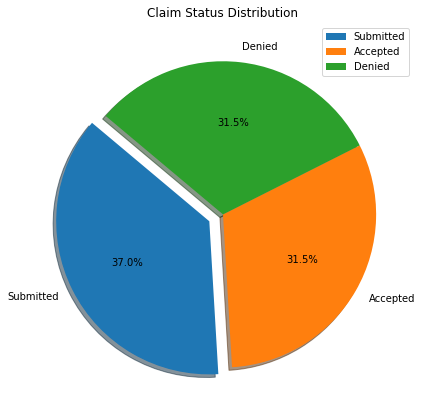

In [48]:
import matplotlib.pyplot as plt

# Count of each status
status_counts = df['Claim_Status'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
explode = (0.1, 0, 0.0)
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True)
plt.title('Claim Status Distribution')
plt.legend(labels=status_counts.index, loc='upper right')
plt.tight_layout()
plt.show()

## Bar Chart – Top 5 Denial Reasons


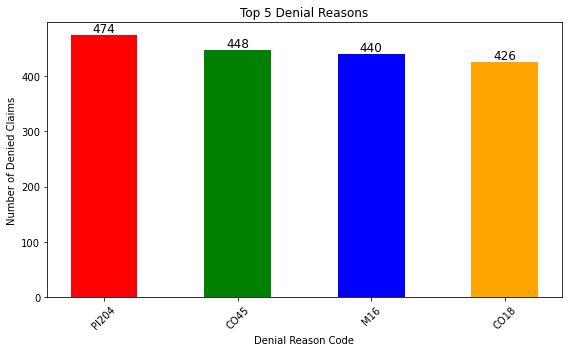

In [58]:
import matplotlib.pyplot as plt

denial_codes = top_denials.index
denial_counts = top_denials.values

colors = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(8,5))
bars = plt.bar(denial_codes, denial_counts, color=colors, width=0.5)

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom', fontsize=12)

plt.title('Top 5 Denial Reasons')
plt.xlabel('Denial Reason Code')
plt.ylabel('Number of Denied Claims')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Line Chart – Average Days to Process Over Time


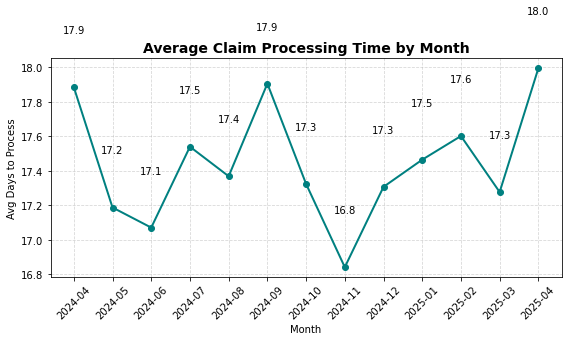

In [63]:
import matplotlib.pyplot as plt

# Drop rows with missing data
df_time = df.dropna(subset=['Claim_Submit_Date', 'Days_To_Process']).copy()

# Group by month
df_time['Month'] = df_time['Claim_Submit_Date'].dt.to_period('M')
monthly_avg = df_time.groupby('Month')['Days_To_Process'].mean()

# Convert PeriodIndex to string for display
months = monthly_avg.index.astype(str)
values = monthly_avg.values

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(months, values, marker='o', linestyle='-', color='teal', linewidth=2)

# Add labels on each point
for i, value in enumerate(values):
    plt.text(i, value + 0.3, f"{value:.1f}", ha='center', va='bottom', fontsize=10)

# Style
plt.title('Average Claim Processing Time by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Avg Days to Process')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Bar Chart – Total Billed vs. Paid Amount


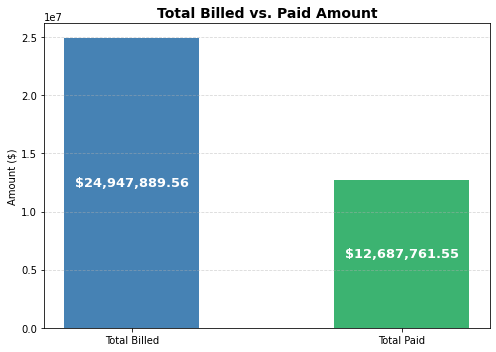

In [67]:
import matplotlib.pyplot as plt

# Values and labels
amounts = [total_billed, total_paid]
labels = ['Total Billed', 'Total Paid']
colors = ['steelblue', 'mediumseagreen']

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, amounts, color=colors, width=0.5)

# Adding $ values inside each bar
for bar in bars:
    yval = bar.get_height()
    label = f"${yval:,.2f}"
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, label,
             ha='center', va='center', color='white', fontsize=13, fontweight='bold')

# Title and axis formatting
plt.title('Total Billed vs. Paid Amount', fontsize=14, fontweight='bold')
plt.ylabel('Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Denial Rate by Provider

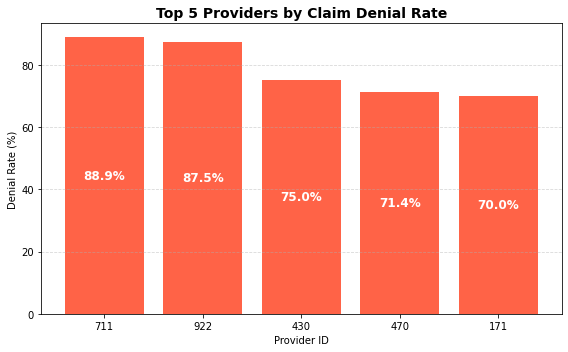

In [68]:
# Group by Provider and calculate denial rate
provider_denial_rate = df.groupby('Provider_ID')['Is_Denied'].mean().sort_values(ascending=False).head(5) * 100

# Bar chart with data labels
plt.figure(figsize=(8,5))
bars = plt.bar(provider_denial_rate.index.astype(str), provider_denial_rate.values, color='tomato')

# Add percentages inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f"{yval:.1f}%", ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.title('Top 5 Providers by Claim Denial Rate', fontsize=14, fontweight='bold')
plt.xlabel('Provider ID')
plt.ylabel('Denial Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##  Average Lag Between Service & Submission

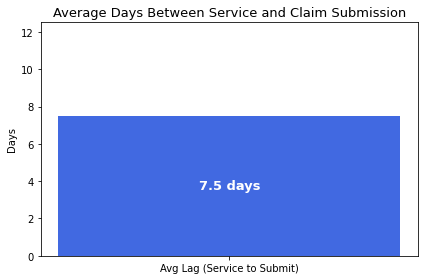

In [77]:
# Clean rows with missing values
valid_lag = df['Days_Between_Service_And_Submit'].dropna()

avg_lag = valid_lag.mean()

# Simple KPI visual using a single bar
plt.figure(figsize=(6,4))
bar = plt.bar(['Avg Lag (Service to Submit)'], [avg_lag], color='royalblue')

# Add value inside bar
plt.text(0, avg_lag/2, f"{avg_lag:.1f} days", ha='center', va='center', color='white', fontsize=13, fontweight='bold')

plt.title('Average Days Between Service and Claim Submission', fontsize=13)
plt.ylabel('Days')
plt.ylim(0, max(avg_lag + 5, 10))
plt.tight_layout()
plt.show()
